In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# data preparation

## loading in

In [4]:
%%cmd
curl -o input.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

#can also use os.system("curl ###") as an alternative

Microsoft Windows [Version 10.0.22631.3447]
(c) Microsoft Corporation. All rights reserved.

(base) c:\Users\bruno\OneDrive\Documents\Code\python\deep_learning\Karpathy\chatgpt_>curl -o input.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1089k  100 1089k    0     0  2495k      0 --:--:-- --:--:-- --:--:-- 2509k



(base) c:\Users\bruno\OneDrive\Documents\Code\python\deep_learning\Karpathy\chatgpt_>
(base) c:\Users\bruno\OneDrive\Documents\Code\python\deep_learning\Karpathy\chatgpt_>#can also use os.system("curl ###") as an alternative


'#can' is not recognized as an internal or external command,
operable program or batch file.



(base) c:\Users\bruno\OneDrive\Documents\Code\python\deep_learning\Karpathy\chatgpt_>

In [5]:
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

In [6]:
len(text)

1115394

In [7]:
text.find("Macbeth")

-1

In [8]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



## create our vocabulary 

since it is a character level model we just need the alphabeta and any special characters we want to use

In [9]:
chars = sorted(list(set(text))) #text is just a sequence of character
# set constructer will return set of all characters that occur in this text
# list will give this set and arbitary ordering which is then sorted
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [10]:
itos = {i:char for i,char in enumerate(chars)}
stoi = {char:i for i,char in itos.items()}
#[(value,key) for key,value in itos.items()]
#itos


## encoder and decoder

this character level encoder is one of the simplest tokenizer or "schema" - other examples include

SentencePiece which google uses - encodes text into integers but into different integers - subword tokenizer

tiktoken - bitpair encoding tokenizer used by openai

TRADE OFF: codebook size and sequence length ##

In [11]:
encode = lambda s: [stoi[c] for c in s] 
# takes a string and outputs a list of integeres
decode = lambda l: "".join([itos[i] for i in l])
# returns a string from a list of integers



In [12]:
import torch
data = torch.tensor(encode(text), dtype = torch.long)


## train val split

simply split after a arbitrary point

In [13]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# training the transformer

we can't feed the entire code into the transformer at once - that would be extremely computationally expensive and ?perhaps unwise

we want to work with chunks of the data - 

these chunks have a maximum length - this is refered to as block size or context length

lets use blocksize = 8

below take out 9 - this provides 8 different pieces of information - 2 follows 1, 3 follows 1,2, 4 follows 1,2,3 etc

In [14]:
block_size = 8
train_data[:block_size+1] #take a block of 9 and predict the last item :)

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [15]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1] #+1 is upto and including
    target = y[t] 
    print(f"when input is {context} the target is: {target}")


when input is tensor([18]) the target is: 47
when input is tensor([18, 47]) the target is: 56
when input is tensor([18, 47, 56]) the target is: 57
when input is tensor([18, 47, 56, 57]) the target is: 58
when input is tensor([18, 47, 56, 57, 58]) the target is: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target is: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target is: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is: 58


training like this makes the transformer more robust as gets used to seeing context raning from lengths of 1 to block_size - this allows us to start to generate from just 1 character

transformer will **never** recieve context larger than block_size when predicting the next character .... hmmmmmm 

?Maybe this is why attnetion is useful as it encodes more context into each pieces of context - this is just my guess

## batch dimension

we have considered hte time dimension - sequence length but we also need to consider how many blocks will be fed in each time as a batch

our batch size 

This is done for efficiency to keep the GPU busy - gpus are very good for parallel processing - ??? each chunk is processed independently within the batch ?????

In [16]:
torch.manual_seed(1337)
batch_size = 4 #how many independent sequences will we process in paralle for each ?forward and backward pass? of hte transformeer
block_size = 8 # maximum size of each input sequence or context

def get_batch(split):
    #samples random locations in the dataset to pull chunk
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) #size argument must be a tuple
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch("train")
print("inputs:")
print(xb)
print("targets:")
print(yb)

for b in range(batch_size): #batch dimension
    for t in range(block_size): #time or sequence dimension
        context = xb[b,:t+1]
        target = yb[b,t]
        print(f"context {context}, target: {target} ")

inputs:
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
context tensor([24]), target: 43 
context tensor([24, 43]), target: 58 
context tensor([24, 43, 58]), target: 5 
context tensor([24, 43, 58,  5]), target: 57 
context tensor([24, 43, 58,  5, 57]), target: 1 
context tensor([24, 43, 58,  5, 57,  1]), target: 46 
context tensor([24, 43, 58,  5, 57,  1, 46]), target: 43 
context tensor([24, 43, 58,  5, 57,  1, 46, 43]), target: 39 
context tensor([44]), target: 53 
context tensor([44, 53]), target: 56 
context tensor([44, 53, 56]), target: 1 
context tensor([44, 53, 56,  1]), target: 58 
context tensor([44, 53, 56,  1, 58]), target: 46 
context tensor([44, 53, 56,  1, 58, 46]), target: 39 


In [17]:
ix = torch.randint(len(data) - block_size, (batch_size,)) 
ix

tensor([1081275,  241627,  748567,  905830])

# feeding this data into simpler models to see how it works

## Bi-gram

In [18]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        #each token directly reads off hte logits for the next toekn from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) #nn.Embedding is a thin wrapper of a tensors of size (vocab_size,vocab_size) essentially a lookup table

    def forward(self, idx, targets=None):

        # idx and targetsa are both (B,T) tensor of integers  
        #simply "embeds" each input (B,T) -> (B,T,C)  
        logits = self.token_embedding_table(idx) # (B,T,C) (Batch, Time, Channel aka vocab_size)
        # we simple extract these channels and interpret them as the "logits" - the scores for the next character in the sequence

        if targets is None:
            # if no targets simply return the logits
            return self.token_embedding_table(idx)
        else:        
            # cross entropy - see documentation - pytorch wants the logits in (-1, C,) format
            B,T,C = logits.shape
            # print(logits[0].shape)
            # print(f"{B},{T},{C}")
            logits = logits.view(B*T, C) #concanate all the batch by adding rows
            targets = targets.clone().view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in hte current context

        #this generates across each batch until reaching max_new_tokens
        for _ in range(max_new_tokens):
            #extract predictions
            logits = self(idx) 
            
            #since bigram each of hte C represents the probability 
            # of each possible vocab option
            
            # 2 options:

            # 1. so we simple extract the max probability value 
            #of the last element of each batch
            #preds = logits.max(2)[1][:,-1,:] #[1] extract positions rather than values
            
            # 2. We sample from this distribution
            logits = logits[:, -1, :] # Extracts last time point - becomes (B,C)
            probs = F.softmax(logits, dim = 1) 
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)

            #and then append it to the current context
            idx = torch.cat((idx,idx_next), dim = 1)

        return idx
            

    

m = BigramModel(vocab_size)
logits, loss = m(xb,yb)
print(logits.shape)
print(loss) 

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


In [19]:
#manually calculating the loss to understand exactly what cross
#entropy is doing

#remember logits can be interpreted as a raw score - unnormalized 

#nn.cross entropy is equivalent to applying log softmax followed by NLLLoss

#print(F.cross_entropy(logits,yb.view(4*8)))

temp = [(logits[position_index,vocab_index],logits[position_index]) for \
 position_index,vocab_index in enumerate(yb.view(4*8))]

#print([(position_index,vocab_index) for position_index,vocab_index in enumerate(yb.view(4*8))])

softmax_ = torch.tensor([torch.exp(i[0])/torch.sum(torch.exp(i[1])) for i in temp])
#print(softmax_)
NLLLoss_ = -torch.log(softmax_) #its improtant that you mean after the log
print(torch.mean(NLLLoss_))


tensor(4.8786)


guessing the loss - we have 65 vocab elements
so 1/65 average probability assigned to correct value
log(1/65) summed over each example - here B*T = 32 - but we are just taking average
so -log(1/65)

our loss is slightly higher - karpathy says this means that out guesses aren't super diffuse but that they have entropy to them



In [20]:
#B,T,C = out.shape
#print(out.shape)
#temp = out.view(B*T,C)
#temp.T.reshape(B,C,-1)


### generating from model

In [21]:
preds = m.token_embedding_table(xb).max(2)[1][:,-1]
print(preds.view(4,-1))
torch.cat((xb,preds.view(4,-1)), dim = 1)
logits =  m.token_embedding_table(xb)
print(logits[:,-1,:].shape)
probs = F.softmax(logits[:,-1,:], dim = 1)
#print(probs)
torch.multinomial(probs,1)

tensor([[60],
        [30],
        [44],
        [62]])
torch.Size([4, 65])


tensor([[60],
        [31],
        [ 7],
        [ 4]])

In [22]:
idx = torch.zeros((1,1), dtype = torch.long)
decode(m.generate(idx,100)[0].tolist())

"\nr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3!"

### training the bigram model

In [23]:
#create a new moder
m = BigramModel(vocab_size)

# create a PYTORCH OPTIMIZER

# using ADAM which is a more advanced and popular 
# optimizer than sgd
optimizer = torch.optim.Adam(m.parameters(), lr = 1e-3)

losses = []

In [24]:
# training loop
batch_size = 32
for steps in range(10000):
    # extract data
    xb, yb = get_batch("train")

    # forward pass
    logits, loss = m(xb,yb)

    #zero gradient?
    optimizer.zero_grad(set_to_none = True)
    
    #store losses - no required for training
    with torch.no_grad():
        losses.append(loss.item())

    # backward pass - will populate the gradients
    loss.backward()

    # run optimizer - to step
    optimizer.step()


In [25]:
logits, loss = m(xb,yb)
print(loss)

tensor(2.4616, grad_fn=<NllLossBackward0>)


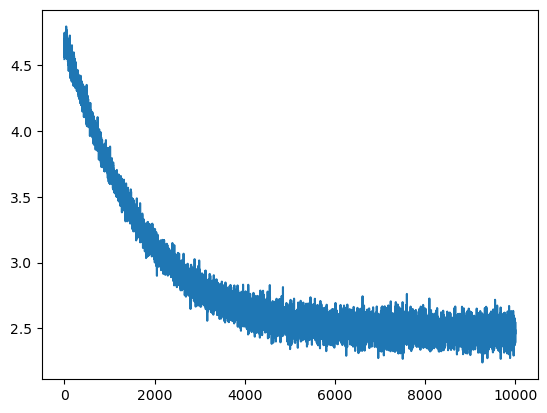

In [26]:
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.plot(losses)

In [27]:
print(decode(m.generate(idx,100)[0].tolist()))




TEE:
NClucor che t thendouilftheesco'imin?
DUESp;
Dupll nn owe hisaloricr
ARI thed de ms, sth ht h


# the mathematical trick in self attention


In [28]:
torch.manual_seed(1337)
B,T,C = 4,8,2 #batch, time, chanel
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

# we want to "temporally" couple the input

# allow the information along the T dimension to interact

# but only allow to "interact" backwards

# e.g. token 5 can talk to 1,2,3,4 but not 6,7,8

Simplest communication is just an average of the tokens (Or a summation)

This interaction is extremely "lossy" - we have lost a lot of information

In [29]:
# we want x[b,t] = mean_{i<=t} x[b,i]
# xbow = bat of words = term when just adding together tockens

xbow = torch.zeros((B,T,C))
for b in range(B): #using a for loop is not efficient
    for t in range(T):
        xprev = x[b,:(t+1)] # (t,C) shape
        xbow[b,t] = torch.mean(xprev, dim = 0) # 0 dimension is time 


# we can do this efficiently using matrix multiplication

# specificially with a lower triangaular matrix - this will give us the sum

In [30]:
torch.tril(torch.ones(3,3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [31]:
# or we can be clever to get the average

t = torch.tril(torch.ones(3,3))
t/t.sum(1).view(3,-1)
t/t.sum(1,keepdim=True)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

# now back to our example x

In [32]:
wei = torch.tril(torch.ones(T,T))#weights
wei = wei / wei.sum(1, keepdim= True)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [33]:
xbow2 = wei @ x # (T,T) @ (B,T,C) -? (B,T,C)
# pytorch will automatically broadcast over 1st dimension 
# cause it sees that only the second matches
# this is a batched matrix multiply
# (B,T,C)
torch.allclose(xbow,xbow2)
torch.allclose(xbow,xbow2,rtol=1e-04)
#xbow
#xbow2

True

Weighted sums based on the the triangular weight matrix

## One other way to rewrite....

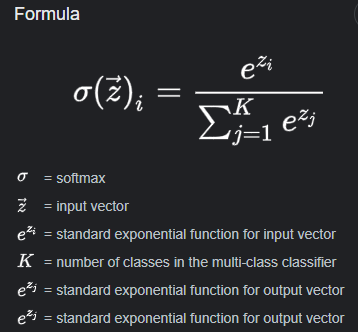

In [34]:
#version 3 using softmax
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float("-inf")) #future cannot commmmunicate with the past
wei = F.softmax(wei, dim=-1) #interesting - e^xn/sum(e^xi)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

this will be the formulation we end up using - you can think of the weights as a sort of interactions strength - how much of each token from the past do we want to aggregate or average up

# Spoiler alert

When we make a transformer these affinities will not just be 0 - but will be data dependent and learned!

## tldr - you can do weighted aggregations of the past elements using matrix multiplication of a lower triangular matrix - the values in this matrix telll us how much of each value to aggregate

# Implementing self attention

implementing a small self attention for a single individual "head"

In [35]:
torch.set_printoptions(4,sci_mode = False) #prevent scientific notation

# version 4: self attention
torch.manual_seed(1337)
B, T, C = 4, 8 , 32
x = torch.randn(B,T,C)

#lets see a single head perform self-attention
head_size = 16 #number of dimensions in the key and bias
key = nn.Linear(C, head_size, bias=False) #bias fals so just a matmul #NOTE THIS IS PART OF HTE NETWORK AND IS "LEARNED" - model learns how to extract keys from each "NODE"
query = nn.Linear(C, head_size, bias = False)
value = nn.Linear(C, head_size, bias=False)


k = key(x) # (B,T,head_size)
q = query(x) # (B,T,head_size)
# each element independently produces a key and a query
# now for the communication - we want
# all the queries to dot product all the keys
wei = q @ k.transpose(-2,-1) # need to transpose K (specifically the last 2 dimensions)\
#(B,T,head_size) @ (B,head_size,T) -> (B,T,T)

# #ignoring the batches for simplicity
# (T,hs) @ (hs,T)
# r1 * c1 = query of token 1 and key of token 1
# r1 * c2 = query of token 1 and key of token 2
# ...

# r2 * c1 = query of token 2 and key of token 1

# matmul = dotproduct so reduces these to a single number
# (T,T) matrix will NOT be symmetrical about the diagnol
# as dot(q1,k3) != dot(k1,q3)

# The query and key are entirely derived from x - which in this example will be the 
# tok_embd + pos_embd
# but this is flexible 
# acutaly position is irrelevant - only useful becuase we are utilizing 
# a pos_embd
# 


tril = torch.tril(torch.ones(T,T)) # (T,T)
wei = wei.masked_fill(tril == 0, float("-inf")) #(B,T,T)
wei = F.softmax(wei,1) # (B,T,T)
#key and query are used to work out weights

v = value(x)
out = wei @ v # (B,T,T) @ (B,T,C) -> (B,T,C)
#the final output will use these weights to combine different
#quantities of past tokens into the current token
# so now each row (of C columns) contains the summated information 
# each row is then fed into a FCLL and then tries to prediction
# again we only use one vector of size embd_dim (C) but now this contains
# all the past information in it WWOWOWOWOOW
# REALLY THINK ABOUT THIS - IT IS BEAUTIFUL

# nodes and tokens - ?interchangable
out

tensor([[[    -0.0039,      0.0219,      0.0040,     -0.0194,     -0.0036,
               0.0186,      0.0025,     -0.0130,     -0.0220,      0.0047,
               0.0044,     -0.0148,     -0.0120,     -0.0121,      0.0071,
               0.0142],
         [     0.0068,     -0.0029,     -0.0021,      0.0007,     -0.0019,
              -0.0006,     -0.0043,     -0.0030,     -0.0036,      0.0085,
               0.0083,     -0.0033,      0.0019,      0.0020,      0.0002,
               0.0157],
         [     0.1528,     -0.0272,     -0.1488,      0.0672,      0.0735,
              -0.0648,      0.0306,      0.0262,     -0.0770,     -0.1980,
               0.0630,      0.0841,     -0.1246,     -0.0376,     -0.0577,
               0.3931],
         [     0.1462,      0.1363,     -0.1293,     -0.1185,      0.1133,
               0.0516,      0.0503,     -0.1090,     -0.2362,     -0.0379,
               0.0193,     -0.0535,     -0.1549,     -0.0775,      0.1452,
               0.4478],
    

# **How self-attention solves this:**

Every single **node/token** at every single position will emit 2 vectors

It will emit 
1. A query vector: "what am I looking for"
2. A key vector: "What do I contain"

the way we get affinities between these tokens is to do a **dot product** of the query and key vectors

This dotproduct is then fed in to create the "wei" matrix

Matching terms will be high and this will be weighted highly - 
Conceptually this is if another token contains what another one is looking for

These vectors will be "learned" and data dependent



## One last step

rather than aggregating the "raw" embeddings we feed them through another linear layer to get the "Value"

v is "what is communicated" - the thing that is actually aggregated 

# Notes on self attention


1. Attention is a **communication mechanism** can be seen as nodes in DAG looking at each other and aggregatting information. A node gets to aggregate information from every node that points to it - this is done in a data dependent manner

Image out graph - first note only points to itself, second nodes is pointed to by 1 and 2, third by 1,2,3 etc...

This is the structure that out directed graph has in the example of **"autoregressive language modelling"** - but it does not have to be this way - attention could be applied to any arbitrary directed graph

2. There is no notion of space - attention acts over a set of vectors - there is not implicit encoding of position which is why we add and explicit position encoding into the nnode/vector - so that the nodes know where they are

This is different to convolution where the position of hte nodes is implicitly ustilized by the convolution - the convolutional filter acts in space

I might have my implicit and explicits the wrong way around hahhaha

3. Each example accross hte batch is processed independently

4. In an "encoder" attention block - just delete teh single line that does masking with tril. Allowing all tokens to communicate. 

Here we have made a "decoder" block which has an autoregresssive format so you have to mask future values 

Attention doesnt care - it supports arbitrary connectivity between nodes

5. "self-attention" means that keys queries and values all come from the same source "x". 

but attentions is much more general than that 

You could have a encoder-decoder transformer that generates queries from x but the keys and values come from a whole seperate exteneral source - "sometiems from encoder blocks" - side nodes hahahahha. This is called

"Cross attention" when we have a seperate source of nodes that we want to pool information from into our nodes

"self attention" is when we just use our nodes

6. Scaled dot-product attention

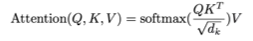

important normalization 

Problem is if you have unit gaussian inputs (0 mean, unit variance) - k and q - the variance of wei will explode - on the order of headsize

multiplying by 1/sqrt(headsize) will fix this and preserve the varaince

wei feeds into sofmax - so it is important at initialization that wei is "diffuse" 

If too much varaince - softmax will be too peaky and converge to one hot encoding - because we exponentiate

See video again if confused

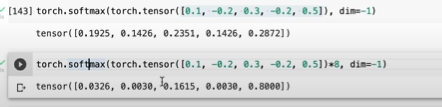

So scaling controlls variance at initialization










### ***side note on autoregressive models***

AR model = The autoregressive model specifies that the output variable depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term); thus the model is in the form of a stochastic difference equation (or recurrence relation) which should not be confused with a differential equation.

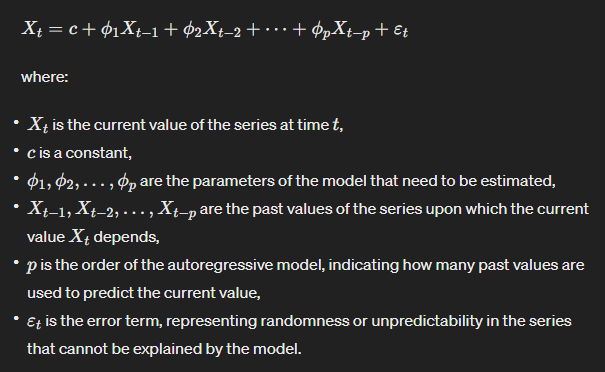

# Multihead attention

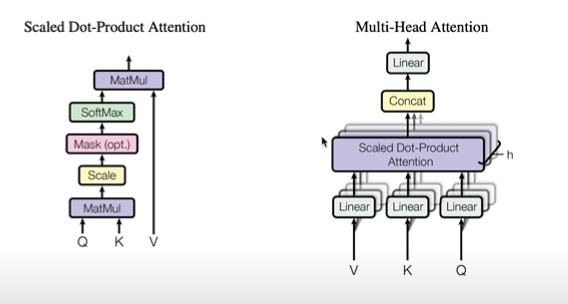

Multiple attentions in parrallel

Similiar to a grouped convolution

In [36]:
#output is then concatenated along the channel dimension

torch.set_printoptions(4,sci_mode = False) #prevent scientific notation

# version 4: self attention
torch.manual_seed(1337)
B, T, C = 4, 8 , 32
x = [torch.randn(B,T,C) for _ in range(10)]

torch.cat(x,dim = 2).shape


torch.Size([4, 8, 320])

# creating blocks

interspese the communication with the computation

So attention and feedforward layers stacked together to make a block

Then add multiple blocks


Problem is when you add blocks you increase depth which makes training non-trivial - much harder


# 2 optimizations drastically help with the training of these stacked blocks

Ensure that the networks remain optimizable



# 1. Skip connections / residual connections

come from paper "Deep Residual Learning for Image Recognition" from Microsoft Research 2015

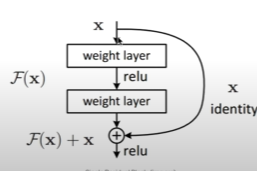

if you have a transform f() the output changes from f(x) to f(x) + x

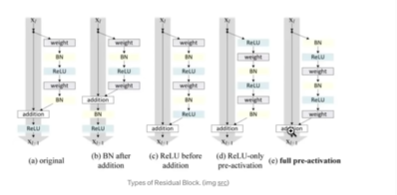

Conceptualization - we have "computation flow"

You can add residual pathways which fork off and perform some computation and then can return to original pathway

Addition distributes gradients equally to both of its inputs 5 -> 5 + 5

So there is a direct pathway from 

"supervision" a.k.a "the gradients from the loss" are directly connected to the inputs via a series of additions

- Gradient superhighway - which forks off into the residual blocks

Over time when training these side braches/residual blocks come online

This dramatically helps with optimization


# 2. layernorm

a paper that came out 2016 - "layer normalization"

very related to batch normalizations

paraphrased - " batchnorm uses the distribution of hte summed input to a neuron over a mini-batch of training cases to compute a mean and variance which are then used to normalize hte summed input to that neuron on each training case - this reduces training time"

Performance is dependednt of bathc size - and not obvious how to apply this to a recurrent neural network

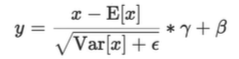

Bathc normalization ensures that across the "batch" dimension - any individual neuron had unit gaussian distribution

Garuntees that the batch dimension will be 0 mean and 1 sd by shifting and scaling the outputs of hte neurons that make up that batch

Layer norm instead normalizes each individual exampe - rather than each feature across a batch

literally just change the dim to 1 instead of 0

Since normalization does not span across example - can be more paralleellized - dont need any "buffers" (e.g. running mean)


In [65]:
class LayerNorm1d
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True #pytroch nn modules have this attribute allow us to make hte module have a different behaviour in trianing vs evaluation 
        
        #parameters (trained with backprop)
        # restore the representational capacity of hte network that might be lost during
        # the normilization process - gives the network flexibility to learn this
        # which has been shown to improve training dynamic and convergence rates

        self.gamma  = torch.ones(dim) #bn gain - if changes then no longer unit normal - model can learn scale for each row
        self.beta = torch.zeros(dim) #gnbias

        #buffers (trainig ith a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)


    def __call__(self,x):
        #calcualte forward pass
        #want to normalize across the rows of x
        
        xmean = x.mean(dim = 1, keepdim = True)
        xvar = x.var(dim = 1, keepdim = True)

        #normalize layer
        xhat =  (x - xmean) / (xvar + self.eps)**0.5 
        self.out = self.gamma * xhat + self.beta

        #update buffers
        if self.training:
            with torch.no_grad(): #context manager for efficiency :)
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        #return output
        return self.out #pytorch does not do a self.out - done to allow some inference, just retur d

    def parameters(self):
        return [self.gamma, self.beta]
    

SyntaxError: expected ':' (1826105075.py, line 1)

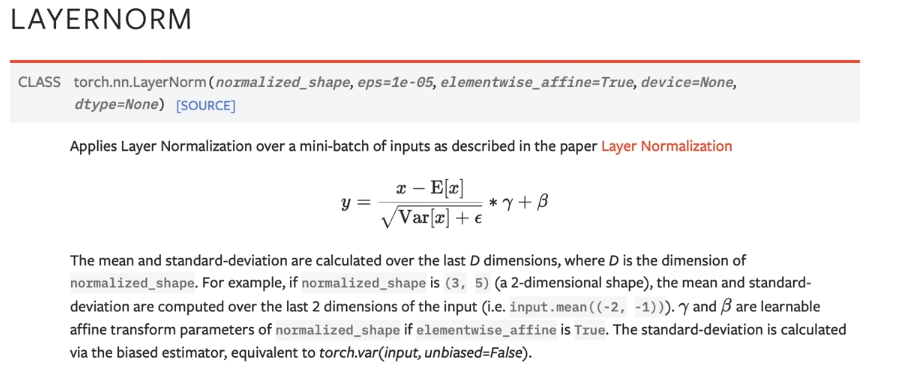

In [64]:
torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32,100) #batch size of 32, 
x = module(x)
print(f"{x[:,0].mean() , x[:,0].std()}")
print(f"{x[0,:].mean() , x[0,:].std()}")

NameError: name 'LayerNorm1d' is not defined

In [76]:
x = torch.randn(4,5,10)
x.sum(dim = 0) # 0 actions sums each row in a column, 1 takes each column in a row
ln1 = nn.LayerNorm(10)
x = ln1(x)
x[0,0,:].mean()


tensor(    -0.0000, grad_fn=<MeanBackward0>)

# Deviation from the original paper!

now layer norm is usually applied **BEFORE** the transformation!

pre-norm formulation

# Last improvement!

# **DROPOUT**

Randomly prevents some of the nodes from communicating

Comes from paper:

"Dropout: A simple way to Prevent Neural Networks from Overfitting"
- From the unversity of toronto (including ilya)

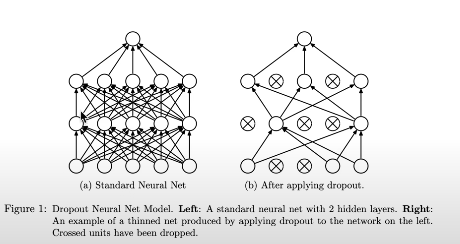

Takes main neural net - every forward-backward pass "shuts off" a subset of neurons

So it technically trains an ensemble of subnetworks that are all switched on at test time

Helps alot with overfitting - good regularisation technique

Common places to add - 
1. Right before the reconnection to the residual pathway
2. End of the multiheaded attention
3. When you calculate affinities after the softmax - this stops some of the nodes communicating through attention

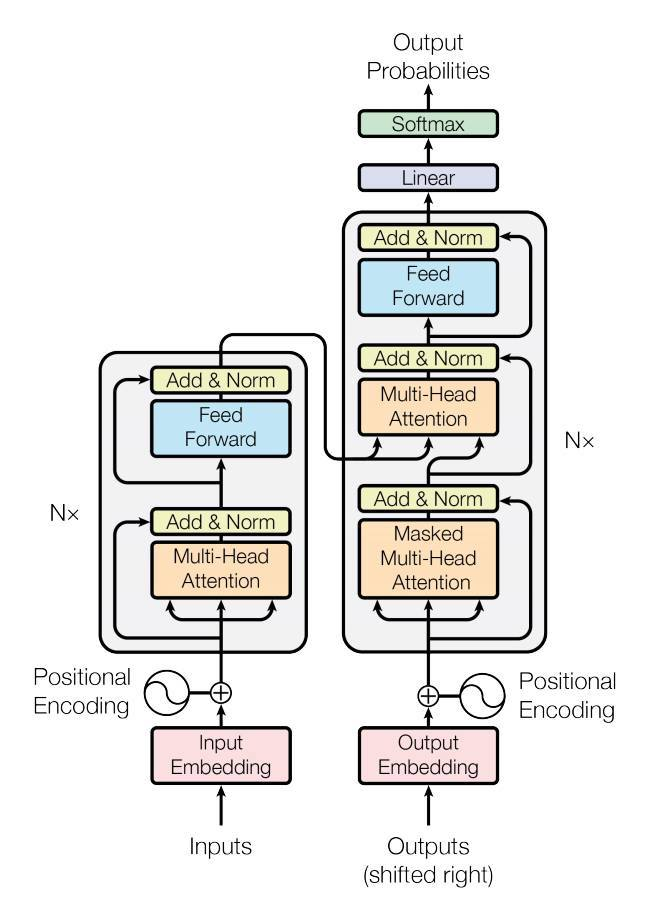

# ENCODING!

So far we have just made a decoder - an autoregressive model (triangular mask) - has self attention and feed forward

Encoder - does the same steps as decoder but outputs 
- Values
- Keys

These are then **"CROSS ATTENTIONED"** with the blocks in hte decoder

Theoretically

This **CONDITIONS** the decoder on the inputs to the encoder

So decoder is CONDITIONED on 
1. Its past outputs
2. The outputs of the encoder (the encoded inputs)

Example:
- Machine translation



# Nano-GPT

2 files 

train.py
Boilerplate to train the neural network
More complicated than our model as it:
-  Saving and loading checkpoint
- Pretrained weights
-  Decaying learning rate 
- Compiling model
-  Distributed training across multiple GPUs
        
model.py
Same as what we have done
- Few small changes
1. Treats each head as a dimension rather than concatenating outputs into 1
2. gelu non-linearity (this is what open-ai used and karpathy wanted to "LOAD THEIR CHECKPOINTS)

To train GPT

2 steps

1. Pre-training
Vocab 50,000 - 
Minishakespear - ~300,000 tokens

GPT 3
- 300 billion tokens

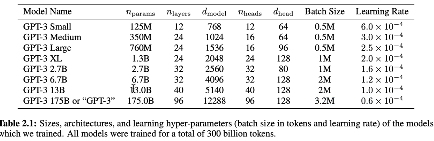

Architecture is very similiar to what we have done
But it becomes a real infastructure challenge

?this is usually a big decoder - think of it as a document autocompleter

2. Fine tuning

Large models are very sample effectient when finetuning
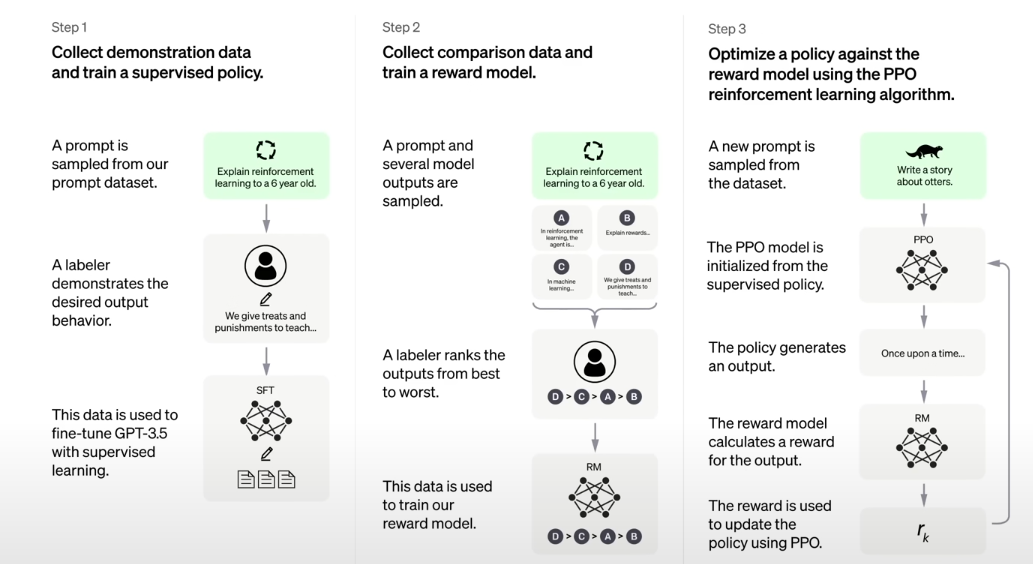

PPO - policy gradient reinforcement learning algorithm